<a href="https://colab.research.google.com/github/Brycexxx/fastai/blob/master/lesson6_pets_more.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lesson 6: pets revisited

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

# from ipyexperiments import *
# exp1 = IPyExperimentsPytorch()


# w/o fixing random memory usage patterns change wildly and it's hard to tune things up this way
if True:
    import torch
    torch.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed_all(42)
    random.seed(42)
    np.random.seed(42)

In [2]:
bs=64
path = untar_data(URLs.PETS)
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [3]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [0]:
path = path / 'images'

### **Data augmentation**

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                    p_affine=1., p_lighting=1.0)

In [0]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
              .transform(tfms, size=size, padding_mode=padding_mode)
              .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
data = get_data(224, bs, 'zeros')

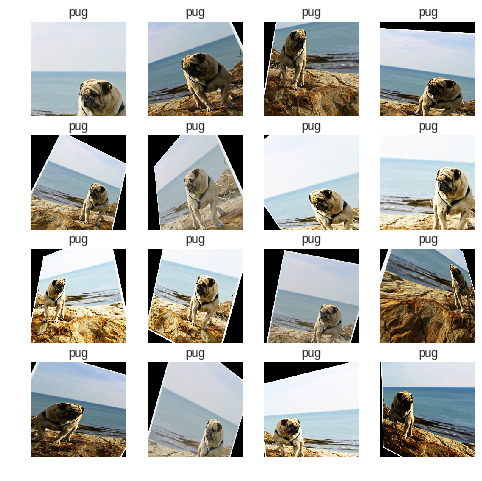

In [9]:
def _plot(i, j, ax):
    x, y = data.train_ds[5]
    x.show(ax, y=y)
    
plot_multi(_plot, 4, 4, figsize=(8, 8))

In [0]:
data = get_data(224, bs)

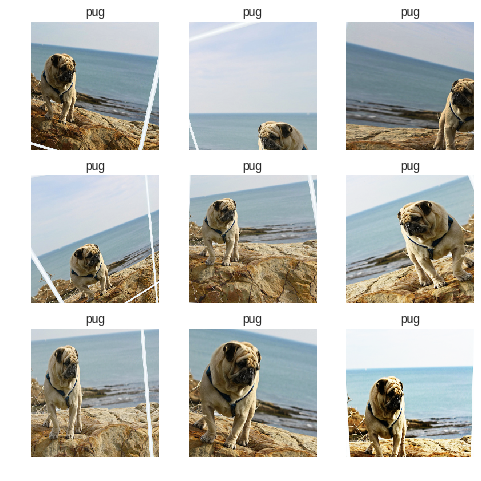

In [11]:
plot_multi(_plot, 3, 3, figsize=(8, 8))

### Train a model

In [12]:
# this is for bs tune up - it will run through fit calls really fast, doing the minimum required to setup gpu requirements

class FitNBatch(Callback):
    def __init__(self, n_batch:int=2): 
        print("init")
        self.stop,self.n_batch = False,n_batch
        
    def on_batch_end(self, iteration, **kwargs):
        if iteration >= self.n_batch: self.stop = True
        print("batch end")
        return self.stop

    def on_epoch_end(self, **kwargs): 
        print("epoch end")
        return self.stop


# True turns the speedup on, False return to normal behavior
tune = True
if tune:
    defaults.extra_callbacks = [FitNBatch()]
else:
    defaults.extra_callbacks = None

init


In [13]:
gc.collect()

38812

In [14]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 82375091.03it/s]


In [15]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [16]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,2.372030,1.068594,0.220568
2,1.382155,0.349671,0.089986
3,0.863710,0.276008,0.073072


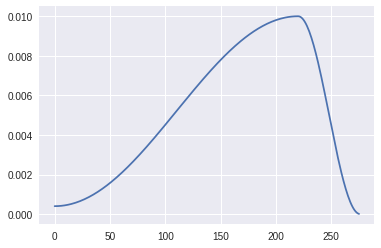

In [17]:
learn.recorder.plot_lr()

In [18]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,0.677655,0.298712,0.071042
2,0.638691,0.293142,0.071042


In [0]:
data = get_data(352, bs=bs)

In [0]:
learn.data = data

In [21]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.612302,0.261667,0.058863
2,0.579758,0.266461,0.053451


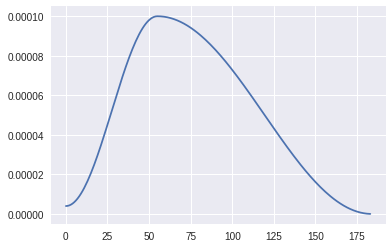

In [22]:
learn.recorder.plot_lr()

In [0]:
learn.save('352')

### Convolution kernel

In [0]:
data = get_data(352, 16)

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category japanese_chin

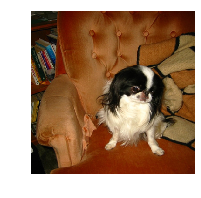

In [26]:
idx=0
x, y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [0]:
k = tensor([
    [0., -5/3, 1],
    [-5/3, -5/3, 1],
    [1., 1., 1.]
]).expand(1, 3, 3, 3) / 6

In [28]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [29]:
k.shape

torch.Size([1, 3, 3, 3])

In [30]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [31]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [0]:
edge = F.conv2d(t[None], k)

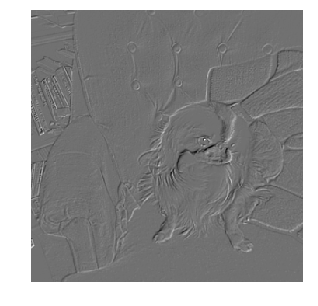

In [33]:
show_image(edge[0], figsize=(5, 5))

In [34]:
data.c

37

In [35]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [36]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 176, 176]    9,408      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 176, 176]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 176, 176]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 88, 88]      0          False     
______________________________________________________________________
Conv2d               [1, 64, 88, 88]      36,864     False     
______________________________________________________________________
BatchNorm2d          [1, 64, 88, 88]      128        True      
______________________________________________________________________
ReLU                 [1, 64, 88, 88]      0          False     
______________________________________________________________

### Heatmap

In [37]:
m = learn.model.eval()
m

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [39]:
xb, xb.shape

(tensor([[[[-0.7479, -0.8314, -0.9220,  ..., -1.4509, -1.4811, -1.4473],
           [-1.2246, -1.2398, -1.2730,  ..., -1.4494, -1.4630, -1.4327],
           [-1.2586, -1.1739, -1.1890,  ..., -1.4289, -1.4440, -1.4264],
           ...,
           [-2.0798, -2.0502, -2.0488,  ..., -0.6223, -0.5789, -0.6320],
           [-2.0836, -2.0659, -2.0494,  ..., -0.5960, -0.5959, -0.6336],
           [-2.0681, -2.0498, -2.0665,  ..., -0.5776, -0.6094, -0.5965]],
 
          [[-0.5826, -0.7020, -0.7956,  ..., -1.8077, -1.7874, -1.7611],
           [-1.1095, -1.1922, -1.2280,  ..., -1.8097, -1.8214, -1.7904],
           [-1.2189, -1.1768, -1.1940,  ..., -1.8252, -1.8065, -1.7886],
           ...,
           [-1.9968, -1.9665, -1.9651,  ..., -1.6819, -1.6326, -1.6537],
           [-2.0006, -1.9825, -1.9656,  ..., -1.6687, -1.6495, -1.6482],
           [-1.9848, -1.9661, -1.9832,  ..., -1.6506, -1.6490, -1.6331]],
 
          [[-0.6541, -0.7900, -0.8835,  ..., -1.8044, -1.8012, -1.7723],
           [-

In [0]:
from fastai.callbacks.hooks import *

未完成。。。。待续